Meilleure solution: [28, 10, 42, 21, 33, 38, 34, 22, 2, 14, 26, 15, 24, 8, 44, 6, 4, 40, 41, 36, 20, 45, 18, 9, 0, 47, 23, 1, 39, 17, 32, 12, 29, 25, 3, 31, 30, 13, 16, 27, 37, 48, 43, 19, 5, 49, 7, 46, 35, 11]
Distance minimale: 6.130363641805433


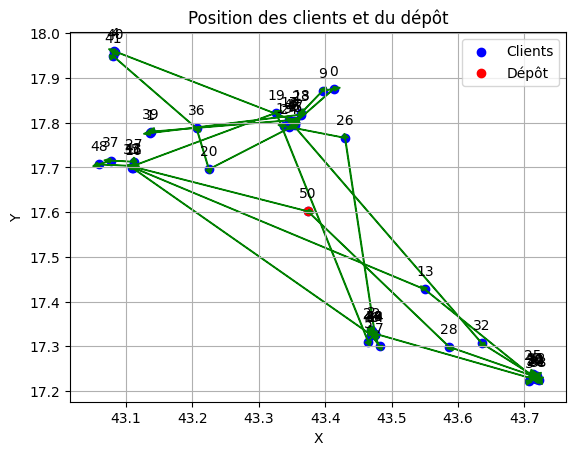

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

df_clients = pd.read_excel('2_detail_table_customers.xls')
df_depot = pd.read_excel('4_detail_table_depots.xls')

# Extraction des informations pertinentes pour les clients
columns_clients = ["CUSTOMER_NUMBER", "CUSTOMER_LATITUDE", "CUSTOMER_LONGITUDE"]
data_clients = df_clients[columns_clients].rename(columns={"CUSTOMER_NUMBER": "number", "CUSTOMER_LATITUDE": "x", "CUSTOMER_LONGITUDE": "y"})
data_clients = data_clients.head(50)
NUM_CLIENTS = len(data_clients)

# Extraction des informations pertinentes pour le dépôt
depot_info = df_depot[['DEPOT_CODE', 'DEPOT_LATITUDE', 'DEPOT_LONGITUDE']].drop_duplicates()
depot_info = depot_info.rename(columns={"DEPOT_CODE": "number", "DEPOT_LATITUDE": "x", "DEPOT_LONGITUDE": "y"})

# Ajout du dépôt aux données clients
data_clients.loc[len(data_clients)] = depot_info.iloc[0]
data_clients[['x', 'y']] = data_clients[['x', 'y']]

# Constantes pour les positions des clients et du dépôt
DEPOT = (data_clients.iloc[-1]['x'], data_clients.iloc[-1]['y'])
client_positions = list(zip(data_clients['x'], data_clients['y']))

# Fonction objectif pour le VRP
def vrp_objective_function(num_vehicles, penalty_factor, distance_matrix, routes):
    total_cost = 0

    # Calculer le coût total des voyages entre les clients pour chaque route
    for route in routes:
        for i in range(len(route) - 1):
            total_cost += distance_matrix[route[i]][route[i+1]]

    # Calculer le nombre de véhicules utilisés
    num_used_vehicles = len(routes)

    # Ajouter le coût des véhicules supplémentaires avec le facteur de pénalité
    total_cost += penalty_factor * (num_used_vehicles - num_vehicles)

    return total_cost

# Fonction pour calculer la distance euclidienne entre deux points
def distance(point1, point2):
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

# Fonction pour évaluer la solution
def evaluate(solution):
    total_distance = 0
    current_location = DEPOT
    for client_idx in solution:
        client_position = client_positions[client_idx]
        total_distance += distance(current_location, client_position)
        current_location = client_position
    total_distance += distance(current_location, DEPOT)
    return total_distance

# Fonction pour générer un voisin en inversant deux éléments de la solution
def generate_neighbor(solution):
    idx1, idx2 = random.sample(range(NUM_CLIENTS), 2)
    neighbor = solution[:]
    neighbor[idx1], neighbor[idx2] = neighbor[idx2], neighbor[idx1]
    return neighbor

# Algorithme de recuit simulé
def simulated_annealing(initial_solution, initial_temperature, cooling_rate, iterations):
    current_solution = initial_solution
    best_solution = current_solution
    current_temperature = initial_temperature

    for _ in range(iterations):
        neighbor_solution = generate_neighbor(current_solution)
        energy_difference = evaluate(neighbor_solution) - evaluate(current_solution)

        if energy_difference < 0 or random.random() < acceptance_probability(energy_difference, current_temperature):
            current_solution = neighbor_solution

        if evaluate(current_solution) < evaluate(best_solution):
            best_solution = current_solution

        current_temperature *= cooling_rate

    return best_solution

# Probabilité d'accepter une solution avec une augmentation d'énergie
def acceptance_probability(energy_difference, temperature):
    return min(1, pow(2.71828, -energy_difference / temperature))

# Initialisation de la solution initiale et des paramètres de l'algorithme
initial_solution = list(range(NUM_CLIENTS))
initial_temperature = 1000
cooling_rate = 0.999
iterations = 10000

# Exécution de l'algorithme de recuit simulé
best_solution = simulated_annealing(initial_solution, initial_temperature, cooling_rate, iterations)

# Affichage de la solution
print("Meilleure solution:", best_solution)
print("Distance minimale:", evaluate(best_solution))

# Tracer les positions des clients et du dépôt
plt.scatter(*zip(*client_positions), color='blue', label='Clients')
plt.scatter(*DEPOT, color='red', label='Dépôt')
for i, (x, y) in enumerate(client_positions):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0,10), ha='center')
current_location = DEPOT
for client_idx in best_solution:
    client_position = client_positions[client_idx]
    plt.arrow(current_location[0], current_location[1], client_position[0] - current_location[0],
              client_position[1] - current_location[1], head_width=0.01, head_length=0.01, fc='green', ec='green')
    current_location = client_position
plt.arrow(current_location[0], current_location[1], DEPOT[0] - current_location[0],
          DEPOT[1] - current_location[1], head_width=0.01, head_length=0.01, fc='green', ec='green')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position des clients et du dépôt')
plt.grid(True)
plt.show()
